In [ ]:
#Install miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local

# Install RDKit
!time conda install -q -y -c conda-forge rdkit==2020.09.2
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-11-07 10:35:29--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-11-07 10:35:29--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M  5.44MB/s    in 56s     

2022-11-07 10:36:25 (1.52 MB/s) - ‘Minico

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/CH453_Assignment2')

Mounted at /content/drive


In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.5 MB 1.2 MB/s 


In [ ]:
# Problem 1
import os
import torch
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcTPSA
import numpy as np

In [ ]:
class Prob1Dataset(Dataset):

    def __init__(self, smi_list):
        super().__init__()

        self.smi_list = smi_list

        ##########Implement Here!##########
        '''
        Get the longest length of smiles in the given smi_list
        '''
        self.max_length = len(max(smi_list, key = len))
        ###################################

        self._set_c_to_i()
        self.vec_dim = self._get_num_char()

    def __len__(self):
        return len(self.smi_list)

    def __getitem__(self, idx):
        '''
        return a dict of {"input": input, "output": output},
        where input is a numpy array of encoded smiles and
        output is a numpy array of corresponding tpsa value.
        use self._encode_smi and self._get_tpsa.
        '''
        sample = dict()
        ##########Implement Here!##########
        sample = {
                "input": self._encode_smi(self.smi_list[idx]),
                "output": self._get_tpsa(self.smi_list[idx])
        }
        ###################################
        return sample

    def _set_c_to_i(self):
        '''
        Obtain c_to_i dictionary from smi_list.
        We'll use the characters in self.smi_list, and auxiliary character 'X'.
        '''
        c_to_i = dict()
        ##########Implement Here!##########
        whole_char = list(reduce(lambda x, y: x | y, \
                [set(smi) for smi in self.smi_list]))
        whole_char.append('X') #### auxiliary character
        c_to_i = {c: i for i, c in enumerate(whole_char)}
        self.c_to_i = c_to_i
        ###################################
        self.c_to_i = c_to_i

    def _get_num_char(self):
        return len(getattr(self, "c_to_i", dict()))

    def _encode_smi(self, smi):
        '''
        return a numpy array of encoded smiles which dimension is [max_length, num_char].
        use self._collate_smi and self._get_one_hot_vector.
        Hint:
          1. First obtain collated smiles
          2. Then change each character of collated smiles to int by c_to_i
          3. Finally make one-hot vector from each int
        '''
        assert self._get_num_char() > 0, "c_to_i undefined"
        ##########Implement Here!##########
        return np.array([self._get_one_hot_vector(self.c_to_i[c], self.vec_dim) \
                for c in self._collate_smi(smi)]) # [N, vec_dim]
        ###################################

    def _collate_smi(self, smi, pad_char='X'):
        '''
        return a collated smiles (str) which is padded with pad_char with length self.max_length.
        '''
        assert len(smi) <= self.max_length, "given smiles longer than the max_length"
        ##########Implement Here!##########
        return smi.ljust(self.max_length, 'X')
        ###################################

    def _get_one_hot_vector(self, idx, vec_dim):
        '''
        return a numpy array of one-hot vector: length vec_dim where idx-th index is 1.
        '''
        ##########Implement Here!##########
        return np.eye(vec_dim)[idx]
        ###################################

    def _get_tpsa(self, smi):
        '''
        return a numpy array of TPSA of given smiles.
        '''
        ##########Implement Here!##########

        ###################################
        return np.array([CalcTPSA(Chem.MolFromSmiles(smi))])


In [ ]:
def random_splitter(dataset, train_ratio, validation_ratio, test_ratio):
    import random
    import copy
    assert train_ratio + validation_ratio + test_ratio == 1.0
    N = len(dataset)
    all_idx = list(range(N))
    random.shuffle(all_idx)

    train_idx = all_idx[:int(train_ratio * N)]
    valid_idx = all_idx[int(train_ratio * N):int(validation_ratio * N)
                                                   + int(train_ratio * N)]
    test_idx = all_idx[int(validation_ratio * N) + int(train_ratio * N):]
    train_dataset = copy.deepcopy(dataset)
    valid_dataset = copy.deepcopy(dataset)
    test_dataset = copy.deepcopy(dataset)
    train_dataset.smi_list = [dataset.smi_list[i] for i in train_idx]
    valid_dataset.smi_list = [dataset.smi_list[i] for i in valid_idx]
    test_dataset.smi_list =  [dataset.smi_list[i] for i in  test_idx]
    return train_dataset, valid_dataset, test_dataset

In [ ]:
import torch
import torch.nn as nn

class LinearRegressor(nn.Module):
    def __init__(self, embedding_dim=64, num_hidden_layers=10, n_char=43, max_len=64):
        super(LinearRegressor, self).__init__()
        ###############################
        ######## Implement Here #######
        ###############################
        self.embedding_dim = embedding_dim
        self.num_hidden_layers = num_hidden_layers
        self.n_char = n_char
        self.max_len = max_len

        hidden_layers = []
        for _ in range(num_hidden_layers):
            hidden_layers.append(
                nn.Linear(
                    embedding_dim*max_len,
                    embedding_dim*max_len,
                ) # in_channels, out_channels,
            )
        self.hidden_layers = nn.ModuleList(hidden_layers)
        self.fc = nn.Linear(embedding_dim*max_len, 1)
        self.embedding = nn.Linear(n_char, embedding_dim, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x):
        retval = None
        ###############################
        ######## Implement Here #######
        ###############################
        retval = x
        # Embedding
        retval = self.embedding(retval)
        #retval = retval.permute((0, 2, 1))
        retval = retval.reshape(retval.size(0), -1)
        # Convolution and activation
        for layer in self.hidden_layers:
            retval = layer(retval)
            retval = self.activation(retval)
        retval = self.fc(retval)
        return retval                         # [B x 1]

class ConvRegressor(nn.Module):
    def __init__(self, n_channel=64, num_conv_layers=10, kernel_size=3, n_char=43, max_len=64, stride=1):
        super(ConvRegressor, self).__init__()
        ###############################
        ######## Implement Here #######
        ###############################
        self.n_channel = n_channel
        self.num_conv_layers = num_conv_layers
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_char = n_char

        conv_layers = []
        for _ in range(num_conv_layers):
            conv_layers.append(
                nn.Conv1d(
                    n_channel,
                    n_channel,
                    kernel_size,
                    stride=1,
                    padding=1
                ) # in_channels, out_channels, kernel_size, stride, padding
            )

        self.conv_layers = nn.ModuleList(conv_layers)
        self.fc = nn.Linear(n_channel*max_len, 1)
        self.embedding = nn.Linear(n_char, n_channel, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x):
        retval = x                                # [B x max_len x n_char]
        # Embedding
        retval = self.embedding(retval)           # [B x max_len x n_channel]
        retval = retval.permute((0, 2, 1))        # [B x n_channel x max_len]
        # Convolution and activation
        for layer in self.conv_layers:
            retval = layer(retval)
            retval = self.activation(retval)
        retval = retval.view(retval.size(0), -1)
        retval = self.fc(retval)                  # [B x 1]
        return retval   # [B x 1]

In [ ]:
from functools import reduce

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0")

In [ ]:
# 1. Load data and preprocessing
file_path = 'assignment_2_smiles.txt'
with open(file_path, 'r') as f:
    smi_list = [l.strip() for l in f.readlines()]

# Define Dataset and Dataloader
dataset = Prob1Dataset(smi_list)
train_dataset, valid_dataset, _ = \
        random_splitter(dataset, 0.9, 0.1, 0.0)
len_max = dataset.max_length
char_len = dataset.vec_dim

from torch.utils.data import DataLoader
data_loaders = {}
data_loaders['train'] = DataLoader(train_dataset, batch_size=128, shuffle = True)
data_loaders['val'] = DataLoader(valid_dataset, batch_size=128, shuffle = False)

# 2. Train model
# Setting learning parameters
num_epoch = 50
loss_fn = nn.MSELoss(reduction='sum')
lr = 1e-4

# prepare model
# model_architecture = 'Linear'
model_architecture = 'Conv'

if model_architecture == 'Linear':
    model = LinearRegressor(embedding_dim=64, num_hidden_layers=10, n_char=char_len, max_len=len_max)
elif model_architecture == 'Conv':
    model = ConvRegressor(n_channel=64, num_conv_layers=10, kernel_size=3, n_char=char_len, max_len=len_max)
print(f'{model_architecture} model was used.')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Model training
import time, copy
model.cuda()
train_loss_history = []
val_loss_history = []
best_val_loss = 1e6
train_start = time.time()
for i in range(num_epoch):
    since = time.time()
    # 2-1. Training phase
    model.train()
    train_loss_list = []
    for batch_idx, batch in enumerate(data_loaders['train']):
        ###############################
        ######## Implement Here #######
        ###############################
        x_batch = batch["input"].float().to(device)
        y_batch = batch["output"].float().to(device)

        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        train_loss_list.append(copy.deepcopy(loss.data.cpu().numpy()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_avg_loss = \
            np.sum(np.array(train_loss_list))/len(data_loaders['train'].dataset)
    train_loss_history.append(epoch_train_avg_loss)

    # 2-2. Validation phase
    model.eval()
    val_loss_list = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loaders['val']):
            ###############################
            ######## Implement Here #######
            ###############################
            x_batch = batch["input"].float().to(device)
            y_batch = batch["output"].float().to(device)

            y_pred = model(x_batch)

            loss = loss_fn(y_pred, y_batch)
            val_loss_list.append(loss.data.cpu().numpy())

    epoch_val_avg_loss = \
            np.sum(np.array(val_loss_list))/len(data_loaders['val'].dataset)
    val_loss_history.append(epoch_val_avg_loss)

    if epoch_val_avg_loss < best_val_loss:
        best_epoch = i+1
        best_val_loss = epoch_val_avg_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    # 2-3. print the result
    end = time.time()
    print(f'{i+1}th epoch,')
    print(f'\ttraining loss: {epoch_train_avg_loss:.5f}')
    print(f'\tval loss: {epoch_val_avg_loss:.5f}')
    print(f'\tepoch time: {end-since:.3f}')

save_dir = 'assignment_2_models'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
torch.save(best_model_wts, f'{save_dir}/Best_{model_architecture}_{str(best_epoch)}.pt')
print('-'*10)
print('Train Finished.')
print(f'Training time: {time.time()-train_start:.2f}s')
print(f'The best epoch: {best_epoch}')
print(f'The best val loss: {best_val_loss}')

Conv model was used.
1th epoch,
	training loss: 3465.14533
	val loss: 880.06713
	epoch time: 17.995
2th epoch,
	training loss: 750.16978
	val loss: 510.28950
	epoch time: 11.542
3th epoch,
	training loss: 332.75378
	val loss: 226.23178
	epoch time: 10.121
4th epoch,
	training loss: 156.16331
	val loss: 110.86150
	epoch time: 10.002
5th epoch,
	training loss: 81.49003
	val loss: 72.93836
	epoch time: 10.920
6th epoch,
	training loss: 57.95303
	val loss: 54.14083
	epoch time: 10.234
7th epoch,
	training loss: 47.97540
	val loss: 48.62931
	epoch time: 10.130
8th epoch,
	training loss: 40.61791
	val loss: 40.22609
	epoch time: 11.511
9th epoch,
	training loss: 34.69605
	val loss: 34.24821
	epoch time: 10.234
10th epoch,
	training loss: 29.35376
	val loss: 27.94059
	epoch time: 10.020
11th epoch,
	training loss: 25.64314
	val loss: 23.37036
	epoch time: 10.147
12th epoch,
	training loss: 22.19492
	val loss: 25.69502
	epoch time: 10.097
13th epoch,
	training loss: 17.94430
	val loss: 16.6828

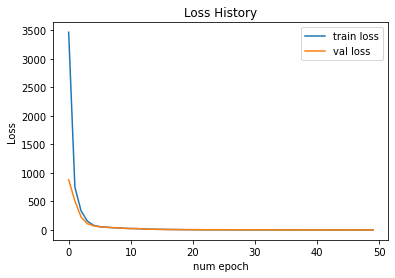

In [ ]:
# 4.Plot the loss histories
import matplotlib.pyplot as plt
x_axis = np.arange(num_epoch)
fig,ax = plt.subplots()
ax.plot(x_axis, train_loss_history, label='train loss')
ax.plot(x_axis, val_loss_history, label='val loss')
ax.set_xlabel('num epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss History')
ax.legend()
fig.show()

In [ ]:
# 1. Load data and preprocessing
file_path = 'assignment_2_smiles.txt'
with open(file_path, 'r') as f:
    smi_list = [l.strip() for l in f.readlines()]

# Define Dataset and Dataloader
dataset = Prob1Dataset(smi_list)
train_dataset, valid_dataset, _ = \
        random_splitter(dataset, 0.9, 0.1, 0.0)
len_max = dataset.max_length
char_len = dataset.vec_dim

from torch.utils.data import DataLoader
data_loaders = {}
data_loaders['train'] = DataLoader(train_dataset, batch_size=128, shuffle = True)
data_loaders['val'] = DataLoader(valid_dataset, batch_size=128, shuffle = False)

# 2. Train model
# Setting learning parameters
num_epoch = 50
loss_fn = nn.MSELoss(reduction='sum')
lr = 1e-4

# prepare model
model_architecture = 'Linear'
#model_architecture = 'Conv'

if model_architecture == 'Linear':
    model = LinearRegressor(embedding_dim=64, num_hidden_layers=10, n_char=char_len, max_len=len_max)
elif model_architecture == 'Conv':
    model = ConvRegressor(n_channel=64, num_conv_layers=10, kernel_size=3, n_char=char_len, max_len=len_max)
print(f'{model_architecture} model was used.')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Model training
import time, copy
model.cuda()
train_loss_history = []
val_loss_history = []
best_val_loss = 1e6
train_start = time.time()
for i in range(num_epoch):
    since = time.time()
    # 2-1. Training phase
    model.train()
    train_loss_list = []
    for batch_idx, batch in enumerate(data_loaders['train']):
        ###############################
        ######## Implement Here #######
        ###############################
        x_batch = batch["input"].float().to(device)
        y_batch = batch["output"].float().to(device)

        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        train_loss_list.append(copy.deepcopy(loss.data.cpu().numpy()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_avg_loss = \
            np.sum(np.array(train_loss_list))/len(data_loaders['train'].dataset)
    train_loss_history.append(epoch_train_avg_loss)

    # 2-2. Validation phase
    model.eval()
    val_loss_list = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loaders['val']):
            ###############################
            ######## Implement Here #######
            ###############################
            x_batch = batch["input"].float().to(device)
            y_batch = batch["output"].float().to(device)

            y_pred = model(x_batch)

            loss = loss_fn(y_pred, y_batch)
            val_loss_list.append(loss.data.cpu().numpy())

    epoch_val_avg_loss = \
            np.sum(np.array(val_loss_list))/len(data_loaders['val'].dataset)
    val_loss_history.append(epoch_val_avg_loss)

    if epoch_val_avg_loss < best_val_loss:
        best_epoch = i+1
        best_val_loss = epoch_val_avg_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    # 2-3. print the result
    end = time.time()
    print(f'{i+1}th epoch,')
    print(f'\ttraining loss: {epoch_train_avg_loss:.5f}')
    print(f'\tval loss: {epoch_val_avg_loss:.5f}')
    print(f'\tepoch time: {end-since:.3f}')

save_dir = 'assignment_2_models'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
torch.save(best_model_wts, f'{save_dir}/Best_{model_architecture}_{str(best_epoch)}.pt')
print('-'*10)
print('Train Finished.')
print(f'Training time: {time.time()-train_start:.2f}s')
print(f'The best epoch: {best_epoch}')
print(f'The best val loss: {best_val_loss}')

Linear model was used.
1th epoch,
	training loss: 852.36817
	val loss: 228.83691
	epoch time: 31.287
2th epoch,
	training loss: 164.55849
	val loss: 108.34253
	epoch time: 31.642
3th epoch,
	training loss: 79.70447
	val loss: 74.63292
	epoch time: 31.400
4th epoch,
	training loss: 73.64092
	val loss: 78.00728
	epoch time: 31.397
5th epoch,
	training loss: 39.14536
	val loss: 52.81660
	epoch time: 31.477
6th epoch,
	training loss: 70.36649
	val loss: 57.49474
	epoch time: 31.408
7th epoch,
	training loss: 31.59529
	val loss: 47.02222
	epoch time: 31.633
8th epoch,
	training loss: 20.73062
	val loss: 50.12559
	epoch time: 31.577
9th epoch,
	training loss: 177.62322
	val loss: 460.65584
	epoch time: 31.428
10th epoch,
	training loss: 52.97769
	val loss: 45.03043
	epoch time: 31.996
11th epoch,
	training loss: 16.95484
	val loss: 50.88469
	epoch time: 31.474
12th epoch,
	training loss: 10.88293
	val loss: 37.09796
	epoch time: 31.411
13th epoch,
	training loss: 7.18123
	val loss: 38.75133


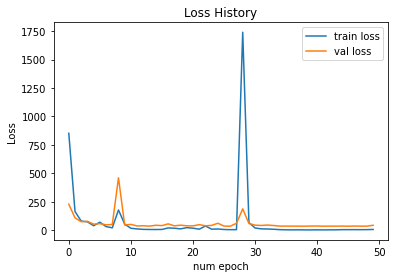

In [ ]:
import matplotlib.pyplot as plt
x_axis = np.arange(num_epoch)
fig,ax = plt.subplots()
ax.plot(x_axis, train_loss_history, label='train loss')
ax.plot(x_axis, val_loss_history, label='val loss')
ax.set_xlabel('num epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss History')
ax.legend()
fig.show()

In [ ]:
model.load_state_dict(torch.load('assignment_2_models/Best_Linear_46.pt', map_location="cuda:0"))

<All keys matched successfully>

In [ ]:
for key in model.state_dict().keys():
    print(f"{key}: {model.state_dict()[key].size()}")

hidden_layers.0.weight: torch.Size([6144, 6144])
hidden_layers.0.bias: torch.Size([6144])
hidden_layers.1.weight: torch.Size([6144, 6144])
hidden_layers.1.bias: torch.Size([6144])
hidden_layers.2.weight: torch.Size([6144, 6144])
hidden_layers.2.bias: torch.Size([6144])
hidden_layers.3.weight: torch.Size([6144, 6144])
hidden_layers.3.bias: torch.Size([6144])
hidden_layers.4.weight: torch.Size([6144, 6144])
hidden_layers.4.bias: torch.Size([6144])
hidden_layers.5.weight: torch.Size([6144, 6144])
hidden_layers.5.bias: torch.Size([6144])
hidden_layers.6.weight: torch.Size([6144, 6144])
hidden_layers.6.bias: torch.Size([6144])
hidden_layers.7.weight: torch.Size([6144, 6144])
hidden_layers.7.bias: torch.Size([6144])
hidden_layers.8.weight: torch.Size([6144, 6144])
hidden_layers.8.bias: torch.Size([6144])
hidden_layers.9.weight: torch.Size([6144, 6144])
hidden_layers.9.bias: torch.Size([6144])
fc.weight: torch.Size([1, 6144])
fc.bias: torch.Size([1])
embedding.weight: torch.Size([64, 37])


In [ ]:
model = ConvRegressor(n_channel=64, num_conv_layers=10, kernel_size=3, n_char=char_len, max_len=len_max)
model.load_state_dict(torch.load('assignment_2_models/Best_Conv_50.pt', map_location="cuda:0"))

<All keys matched successfully>

In [ ]:
for key in model.state_dict().keys():
    print(f"{key}: {model.state_dict()[key].size()}")

conv_layers.0.weight: torch.Size([64, 64, 3])
conv_layers.0.bias: torch.Size([64])
conv_layers.1.weight: torch.Size([64, 64, 3])
conv_layers.1.bias: torch.Size([64])
conv_layers.2.weight: torch.Size([64, 64, 3])
conv_layers.2.bias: torch.Size([64])
conv_layers.3.weight: torch.Size([64, 64, 3])
conv_layers.3.bias: torch.Size([64])
conv_layers.4.weight: torch.Size([64, 64, 3])
conv_layers.4.bias: torch.Size([64])
conv_layers.5.weight: torch.Size([64, 64, 3])
conv_layers.5.bias: torch.Size([64])
conv_layers.6.weight: torch.Size([64, 64, 3])
conv_layers.6.bias: torch.Size([64])
conv_layers.7.weight: torch.Size([64, 64, 3])
conv_layers.7.bias: torch.Size([64])
conv_layers.8.weight: torch.Size([64, 64, 3])
conv_layers.8.bias: torch.Size([64])
conv_layers.9.weight: torch.Size([64, 64, 3])
conv_layers.9.bias: torch.Size([64])
fc.weight: torch.Size([1, 6144])
fc.bias: torch.Size([1])
embedding.weight: torch.Size([64, 37])


# Problem 2

In [ ]:
from rdkit.Chem.FragmentMatcher import FragmentMatcher


class Prob2Dataset(Prob1Dataset):

    def __init__(self, smi_list):
        super().__init__(smi_list)

        self.smi_list = [self._kekulize_smi(s) for s in smi_list]

        ##########Implement Here!##########
        '''
        Get the longest length of smiles in the given smi_list
        '''
        self.max_length = len(max(self.smi_list, key = len))
        ###################################

        self._set_c_to_i()
        self.vec_dim = self._get_num_char()

    def __getitem__(self, idx):
        '''
        return a dict of {"input": input, "output": output},
        where input is a numpy array of encoded smiles and
        output is a numpy array of corresponding label.
        use self._encode_smi and self._has_benzene_substruct.
        '''
        sample = dict()
        ##########Implement Here!##########
        sample = {
                "input": self._encode_smi(self.smi_list[idx]),
                "output": self._has_benzene_substruct(self.smi_list[idx])
        }
        ###################################
        return sample

    def _kekulize_smi(self, smi):
        mol = Chem.MolFromSmiles(smi)
        Chem.Kekulize(mol)
        ksmi = Chem.MolToSmiles(mol, kekuleSmiles=True)
        return ksmi

    def _has_benzene_substruct(self, smi):
        FRAGMENT = "c1ccccc1"
        matcher = FragmentMatcher()
        matcher.Init(FRAGMENT)
        mol = Chem.MolFromSmiles(smi)
        if matcher.HasMatch(mol):
            return 1
        return 0

In [ ]:
import torch.nn as nn

class ConvClassifier(nn.Module):

    def __init__(self, n_channel=128, num_conv_layers=5, padding=1, kernel_size=3, stride=1, n_char=37, fc_dim=None):
        super(ConvClassifier, self).__init__()
        print(f"model's num_conv_layers : {num_conv_layers}")
        print(f"model's padding : {padding}")
        print(f"model's kernel_size : {kernel_size}")
        print(f"model's stride : {stride}")
        ###############################
        ######## Implement Here #######
        ###############################
        self.n_channel = n_channel
        self.num_conv_layers = num_conv_layers
        self.padding = padding
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_char = n_char
        self.fc_dim = fc_dim
        self.max_len = max_len

        conv_layers = []
        for _ in range(num_conv_layers):
            conv_layers.append(
                nn.Conv1d(
                    n_channel,
                    n_channel,
                    kernel_size,
                    stride,
                    padding
                ) # in_channels, out_channels, kernel_size, stride, padding
            )

        self.conv_layers = nn.ModuleList(conv_layers)
        self.fc = nn.Linear(n_channel*(max_len+stride)//8, fc_dim)
        self.embedding = nn.Linear(n_char, n_channel, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x):
        retval = None
        ###############################
        ######## Implement Here #######
        ###############################
        retval = x                                # [B x max_len x n_char]
        # Embedding
        retval = self.embedding(retval)           # [B x max_len x n_channel]
        retval = retval.permute((0, 2, 1))        # [B x n_channel x max_len]
        # Convolution and activation
        for layer in self.conv_layers:
            retval = layer(retval)
            retval = self.activation(retval)
        retval = retval.view(retval.size(0), -1)
        retval = self.fc(retval)                  # [B x 1]
        return retval

In [ ]:
# 1. Load data and preprocessing
file_path = 'assignment_2_smiles.txt'
with open(file_path, 'r') as f:
    smi_list = [l.strip() for l in f.readlines()]

# Define Dataset and Dataloader
dataset = Prob2Dataset(smi_list)
train_dataset, valid_dataset, _ = \
        random_splitter(dataset, 0.9, 0.1, 0.0)
max_len = dataset.max_length
char_len = dataset.vec_dim


from torch.utils.data import DataLoader
data_loaders = {}
data_loaders['train'] = DataLoader(train_dataset, batch_size=128, shuffle = True)
data_loaders['val'] = DataLoader(valid_dataset, batch_size=128, shuffle = False)

# 2. Train model
# Setting learning parameters
num_epoch = 100
loss_fn = nn.CrossEntropyLoss(reduction='sum')
lr = 1e-4
gamma = 0.99
n_channel = 128

# prepare model
#model = ConvClassifier(n_channel=n_channel, num_conv_layers=3, padding=1, kernel_size=3, stride=1, n_char=char_len, fc_dim = 2)  # Model 1
#model = ConvClassifier(n_channel=n_channel, num_conv_layers=3, padding=2, kernel_size=5, stride=1, n_char=char_len, fc_dim = 2)  # Model 2
model = ConvClassifier(n_channel=n_channel, num_conv_layers=3, padding=1, kernel_size=3, stride=2, n_char=char_len, fc_dim = 2)  # Model 3

print('ConvClassifier model was used.')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

model's num_conv_layers : 3
model's padding : 1
model's kernel_size : 3
model's stride : 2
ConvClassifier model was used.


In [ ]:
# Model training
import time, copy
model.cuda()
train_loss_history = []
val_loss_history = []
best_val_loss = 1e6
train_start = time.time()
for i in range(num_epoch):
    since = time.time()
    # 2-1. Training phase
    model.train()
    train_loss_list = []
    for batch_idx, batch in enumerate(data_loaders['train']):
        ###############################
        ######## Implement Here #######
        ###############################
        x_batch = batch["input"].float().to(device)
        y_batch = batch["output"].long().to(device)

        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        train_loss_list.append(copy.deepcopy(loss.data.cpu().numpy()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_avg_loss = \
            np.sum(np.array(train_loss_list))/len(data_loaders['train'].dataset)
    train_loss_history.append(epoch_train_avg_loss)

    # 2-2. Validation phase
    model.eval()
    val_loss_list = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loaders['val']):
            ###############################
            ######## Implement Here #######
            ###############################
            x_batch = batch["input"].float().to(device)
            y_batch = batch["output"].long().to(device)

            y_pred = model(x_batch)

            loss = loss_fn(y_pred, y_batch)
            val_loss_list.append(loss.data.cpu().numpy())

    epoch_val_avg_loss = \
            np.sum(np.array(val_loss_list))/len(data_loaders['val'].dataset)
    val_loss_history.append(epoch_val_avg_loss)

    if epoch_val_avg_loss < best_val_loss:
        best_epoch = i+1
        best_val_loss = epoch_val_avg_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    # 2-3. print the result
    end = time.time()
    print(f'{i+1}th epoch,')
    print(f'\ttraining loss: {epoch_train_avg_loss:.5f}')
    print(f'\tval loss: {epoch_val_avg_loss:.5f}')
    print(f'\tepoch time: {end-since:.3f}')
    scheduler.step()


save_dir = 'assignment_2_models'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
torch.save(best_model_wts, f'{save_dir}/Best_ConvClassifier_{str(best_epoch)}.pt')
print('-'*10)
print('Train Finished.')
print(f'Training time: {time.time()-train_start:.2f}s')
print(f'The best epoch: {best_epoch}')
print(f'The best val loss: {best_val_loss}')

1th epoch,
	training loss: 0.42757
	val loss: 0.30519
	epoch time: 10.980
2th epoch,
	training loss: 0.26991
	val loss: 0.22067
	epoch time: 10.894
3th epoch,
	training loss: 0.16254
	val loss: 0.14060
	epoch time: 12.345
4th epoch,
	training loss: 0.11218
	val loss: 0.10694
	epoch time: 12.412
5th epoch,
	training loss: 0.09398
	val loss: 0.09400
	epoch time: 10.883
6th epoch,
	training loss: 0.08008
	val loss: 0.08912
	epoch time: 10.786
7th epoch,
	training loss: 0.06980
	val loss: 0.07809
	epoch time: 11.305
8th epoch,
	training loss: 0.06060
	val loss: 0.06940
	epoch time: 10.762
9th epoch,
	training loss: 0.05496
	val loss: 0.06379
	epoch time: 12.248
10th epoch,
	training loss: 0.04937
	val loss: 0.08535
	epoch time: 11.389
11th epoch,
	training loss: 0.04708
	val loss: 0.06508
	epoch time: 10.881
12th epoch,
	training loss: 0.04380
	val loss: 0.05631
	epoch time: 11.219
13th epoch,
	training loss: 0.04034
	val loss: 0.05401
	epoch time: 10.791
14th epoch,
	training loss: 0.0379

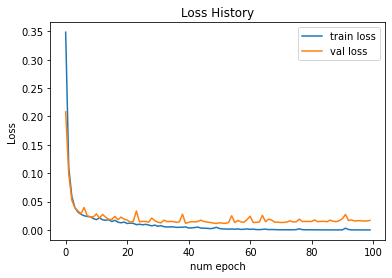

In [ ]:
# 4.Plot the loss histories
import matplotlib.pyplot as plt
x_axis = np.arange(num_epoch)
fig,ax = plt.subplots()
ax.plot(x_axis, train_loss_history, label='train loss')
ax.plot(x_axis, val_loss_history, label='val loss')
ax.set_xlabel('num epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss History')
ax.legend()
fig.show()

In [ ]:
model.load_state_dict(torch.load('assignment_2_models/Best_ConvClassifier_93.pt', map_location="cuda:0"))

<All keys matched successfully>

In [ ]:
for key in model.state_dict().keys():
    print(f"{key}: {model.state_dict()[key].size()}")

conv_layers.0.weight: torch.Size([128, 128, 3])
conv_layers.0.bias: torch.Size([128])
conv_layers.1.weight: torch.Size([128, 128, 3])
conv_layers.1.bias: torch.Size([128])
conv_layers.2.weight: torch.Size([128, 128, 3])
conv_layers.2.bias: torch.Size([128])
fc.weight: torch.Size([2, 1664])
fc.bias: torch.Size([2])
embedding.weight: torch.Size([128, 34])
